In [3]:
import allel
import loompy
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
from collections import defaultdict

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

In [4]:
mskcc_loomfile = 'IR125_P8_IGO_11988_C_4.cells.loom'

with loompy.connect(mskcc_loomfile) as ds:
    print(ds.attrs.keys())
    print(ds.shape)

['CreationDate', 'LOOM_SPEC_VERSION', 'allsites_block', 'chemistry', 'coverage', 'genome_version', 'last_modified', 'mb_loom_version', 'n_reads', 'n_reads_per_cell', 'pipeline_version']
(42406, 2374)


In [5]:
ds = loompy.connect(mskcc_loomfile)

In [902]:
ds.close()

#### data overview

In [6]:
for key in ds.attrs.keys():
    print(f'{key}: {ds.attrs[key]}')

CreationDate: 20210610T062540.376768Z
LOOM_SPEC_VERSION: 2.0.1
allsites_block: 4677
chemistry: V2
coverage: 133
genome_version: hg19
last_modified: 20210610T062540.371512Z
mb_loom_version: 2.2
n_reads: 191541673
n_reads_per_cell: 24732
pipeline_version: 2.0.1


In [7]:
ds.layers.keys()

['', 'AD', 'DP', 'GQ', 'RO']

In [8]:
def generate_heatmap(data):
#     fig, ax = plt.subplots(1,1)
    g = sns.clustermap(data, row_cluster=False, col_cluster=False)
    g.ax_heatmap.set_ylabel('SNVs', fontsize=20)
    g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### What is the number of cells, positions, amplicons?

In [9]:
print(f"number of covered positions is {ds.shape[0]}")
print(f"number of cells is {ds.shape[1]}")
print(f"number of amplicons is {len(np.unique(ds.ra['amplicon']))}")
print(f"number of chromosomes is {len(np.unique(ds.ra['CHROM']))}")

number of covered positions is 42406
number of cells is 2374
number of amplicons is 186
number of chromosomes is 22


#### Q: what is nonref_cells in row attributes?

In [10]:
ds.ra.keys()

['ALT',
 'CHROM',
 'CLNDEF',
 'COMMON',
 'POS',
 'QUAL',
 'REF',
 'RSID',
 'amplicon',
 'id',
 'nonref_cells']

In [11]:
pd.Series(ds.ra['nonref_cells']).value_counts()

0       12004
1        9267
2        6711
3        4510
4        3139
        ...  
460         1
716         1
109         1
237         1
1727        1
Length: 294, dtype: int64

#### position dataframe

In [12]:
df_pos = pd.DataFrame({'pos': list(ds.ra['POS']),
                       'chrom': list(ds.ra['CHROM']),
                       'amplicon': list(ds.ra['amplicon']),
                       'ref': list(ds.ra['REF']),
                       'alt': list(ds.ra['ALT'])})

df_pos['ref_len'] = df_pos['ref'].apply(len)
df_pos['alt_len'] = df_pos['alt'].apply(len)
df_pos['normal'] = (df_pos['ref_len'] == 1) & (df_pos['alt_len'] == 1)

df_pos['index'] = df_pos.index

In [13]:
df_pos

,pos,chrom,amplicon,ref,alt,ref_len,alt_len,normal,index
0,27057731,1,AMPL50980,A,G,1,1,True,0
1,27057731,1,AMPL50980,A,T,1,1,True,1
2,27057736,1,AMPL50980,C,A,1,1,True,2
3,27057736,1,AMPL50980,C,T,1,1,True,3
4,27057737,1,AMPL50980,A,ATCACCTCCATCT,1,13,False,4
...,...,...,...,...,...,...,...,...,...
42401,76777892,X,AMPL70504,T,,1,0,False,42401
42402,76777893,X,AMPL70504,T,C,1,1,True,42402
42403,76777894,X,AMPL70504,C,T,1,1,True,42403
42404,76777894,X,AMPL70504,C,A,1,1,True,42404


In [14]:
df_unique_pos = df_pos.groupby(['pos', 'amplicon']).first().reset_index()

In [15]:
len(df_unique_pos)

36116

In [16]:
df_unique_pos

,pos,amplicon,chrom,ref,alt,ref_len,alt_len,normal,index
0,346979,AMPL87363,16,T,C,1,1,True,29879
1,346980,AMPL87363,16,G,,1,0,False,29880
2,346981,AMPL87363,16,C,,1,0,False,29881
3,346982,AMPL87363,16,A,G,1,1,True,29882
4,346983,AMPL87363,16,C,T,1,1,True,2645
...,...,...,...,...,...,...,...,...,...
36111,198266798,AMPL87266,2,A,G,1,1,True,10137
36112,198266799,AMPL87266,2,G,,1,0,False,10138
36113,198266800,AMPL87266,2,G,,1,0,False,10139
36114,198266801,AMPL87266,2,C,T,1,1,True,649


#### What is the actual number of positions?

In [17]:
print(f"Total number of positions is {len(df_unique_pos)}")

Total number of positions is 36116


#### What is the number of positions covered in each chromosome?

In [18]:
df_unique_pos['chrom'].value_counts()

17    4297
12    2952
3     2689
2     2683
7     2629
1     2475
X     2356
11    2160
19    1770
18    1471
5     1433
10    1335
6     1285
16    1188
4     1027
9      924
20     858
15     826
8      805
13     588
22     208
14     157
Name: chrom, dtype: int64

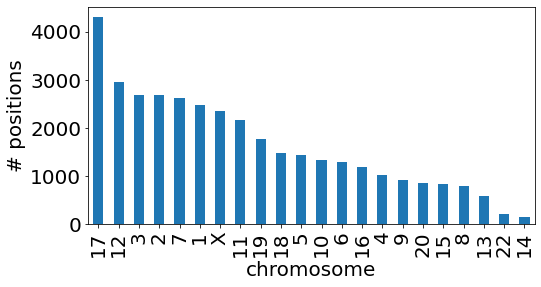

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# positions');

#### what is the number of amplicons in each chromosome?

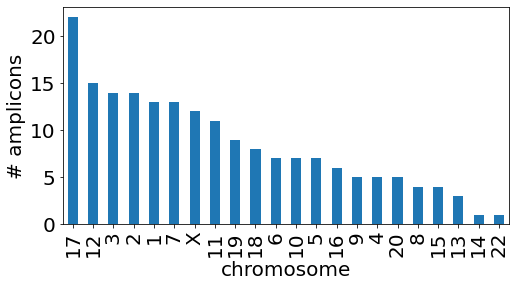

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos.groupby('amplicon').first()['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# amplicons');

#### what is the number of positions in each amplicon

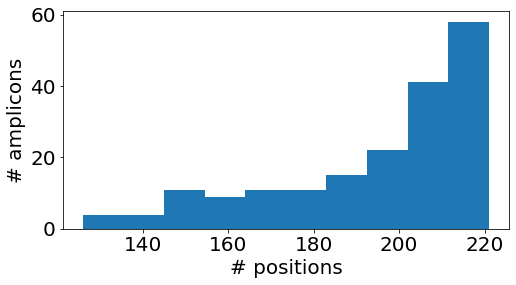

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['amplicon'].value_counts().plot.hist()
plt.gca().set_ylabel('# amplicons');
plt.gca().set_xlabel('# positions');

#### what is the coverage across cells?

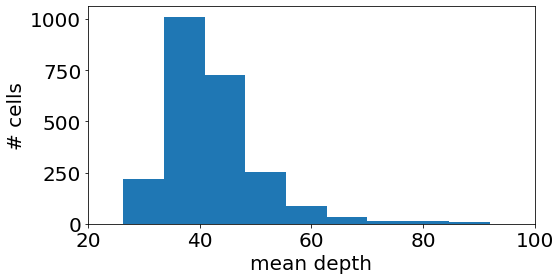

In [22]:
(mean_coverage, ) = ds.layers['DP'].map([np.mean], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(mean_coverage);
plt.gca().set_xlabel('mean depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

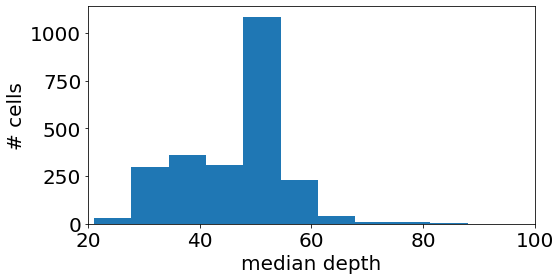

In [23]:
(median_coverage, ) = ds.layers['DP'].map([np.median], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(median_coverage);
plt.gca().set_xlabel('median depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

#### how much does read depth vary within each amplicon?

For each cell $i$ we look at the max read depth $M_{ij}$ and the min read depth $m_{ij}$ across all positions in amplicon $j$. <br>
Then we compute $m_{ij}/M_{ij}$. This is the most extreme factor by which the copy number estimate will vary for positions within amplicon $j$ in cell $i$.

We expect this number to be close to 1 because the read lengths should be comparable with the amplicon lengths. <br>

In [24]:
amplicon_list = list(df_unique_pos['amplicon'].unique())

namplicons = len(amplicon_list)

df_unique_pos = df_unique_pos.sort_values('index')

In [26]:
trim_perc = 0
empty_cells_median = np.zeros((namplicons, 1))

for idx, amplicon in enumerate(amplicon_list):
    selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values
    npos = len(selected_indices)
    if trim_perc > 0:
        cutoff = int(npos // (100 / trim_perc))
    else:
        cutoff = 0
    
    a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]

    median_depths = np.median(a, axis = 0)
    empty_cells_median[idx] = sum(median_depths == 0)

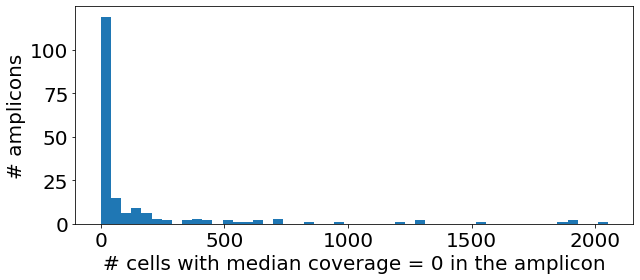

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.hist(empty_cells_median, bins = 50)
plt.gca().set_ylabel('# amplicons', fontsize=20)
plt.gca().set_xlabel('# cells with median coverage = 0 in the amplicon', );

In [28]:
def plot_amplicon_coverage(curr_amplicon, nprobe = 5, trim_perc = 0, read_threshold = 0):
    amplicon_idx = amplicon_list.index(curr_amplicon)
    selected_indices = df_unique_pos[df_unique_pos['amplicon'] == curr_amplicon]['index'].values

    npos = len(selected_indices)
    if trim_perc > 0:
        cutoff = int(npos // (100 / trim_perc))
    else:
        cutoff = 0
    
    a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    
    
    median_depths = np.median(a, axis = 0)
    a_filtered = a[:, median_depths > read_threshold]
    a_filtered_normalized = a_filtered / np.median(a_filtered, axis = 0)
    print(f"rejected {a.shape[1] - a_filtered_normalized.shape[1]} cells for amplicon {curr_amplicon}")
    
    np.random.seed(int(curr_amplicon.lstrip('AMPL')))
    
    fig, ax = plt.subplots(1,1,figsize=(10,4))
        
    if nprobe > 0:
        cell_idx = np.random.randint(a_filtered_normalized.shape[1], size = nprobe)    
        plt.plot(a_filtered_normalized[:,cell_idx], linewidth=3)
    else:
        cell_idx = np.random.randint(a_filtered_normalized.shape[1], size = nprobe)    
        plt.plot(a_filtered_normalized[:, :], 'k', linewidth=3, alpha = 0.05)        
    plt.title(f'{curr_amplicon} coverage for {nprobe} random cells from organoid', fontsize=20)
    plt.gca().set_ylabel('normalized depth')
    plt.gca().set_xlabel('index of position in the amplicon')    

rejected 27 cells for amplicon AMPL87363
rejected 419 cells for amplicon AMPL87294
rejected 653 cells for amplicon AMPL87377
rejected 2 cells for amplicon AMPL87244
rejected 0 cells for amplicon AMPL87358


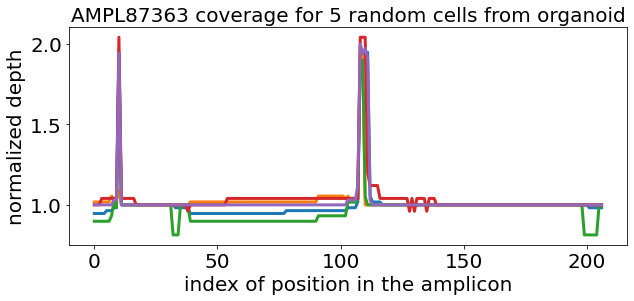

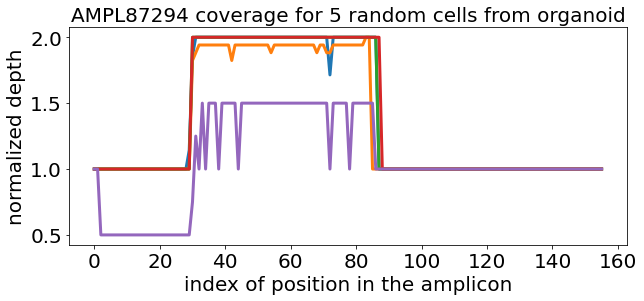

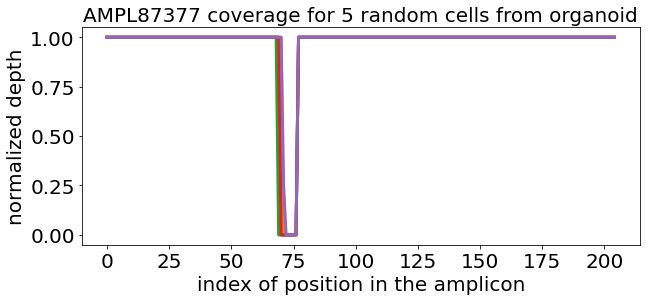

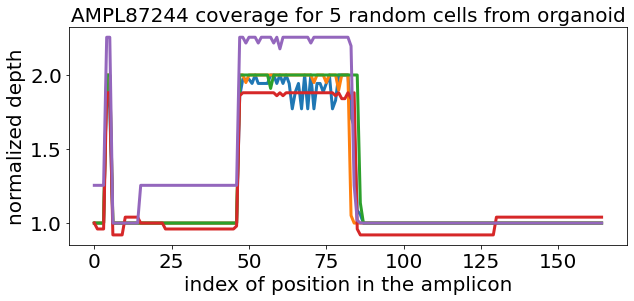

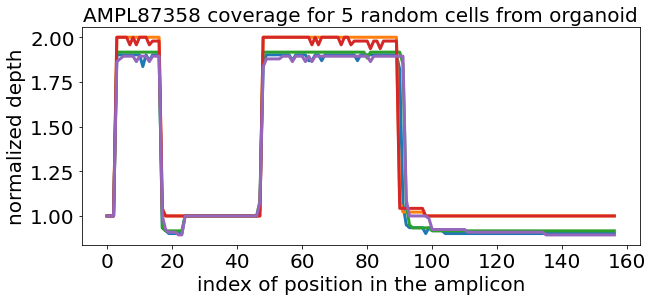

In [29]:
plot_amplicon_coverage(amplicon_list[0])
plot_amplicon_coverage(amplicon_list[4])
plot_amplicon_coverage(amplicon_list[20])
plot_amplicon_coverage(amplicon_list[43])
plot_amplicon_coverage(amplicon_list[140])

rejected 27 cells for amplicon AMPL87363
rejected 419 cells for amplicon AMPL87294
rejected 653 cells for amplicon AMPL87377
rejected 2 cells for amplicon AMPL87244
rejected 0 cells for amplicon AMPL87358


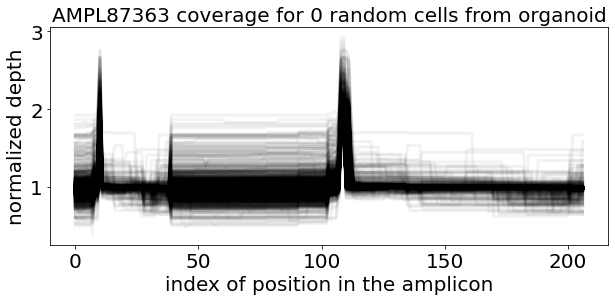

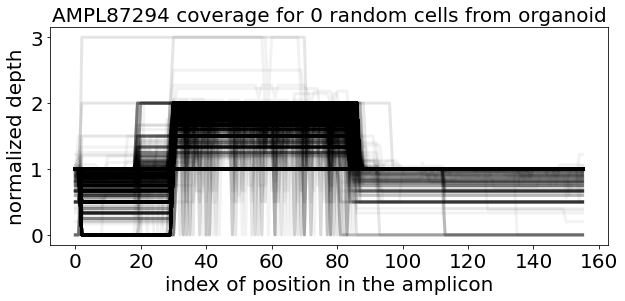

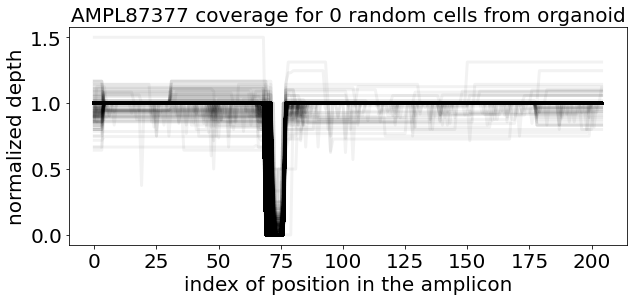

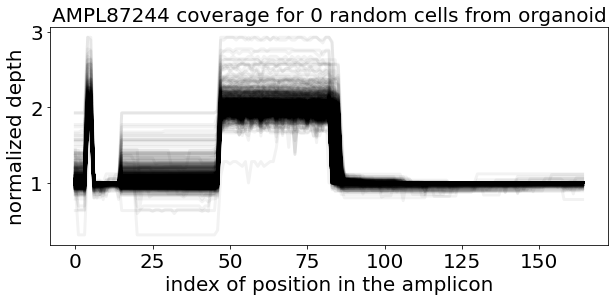

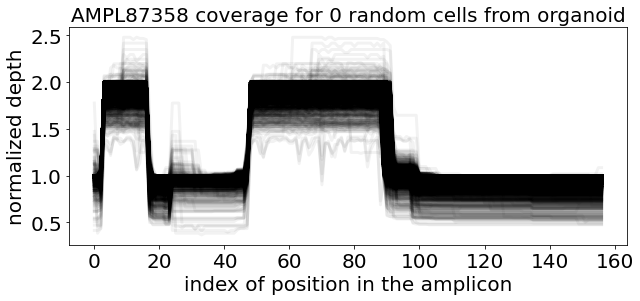

In [30]:
plot_amplicon_coverage(amplicon_list[0], nprobe = 0)
plot_amplicon_coverage(amplicon_list[4], nprobe = 0)
plot_amplicon_coverage(amplicon_list[20], nprobe = 0)
plot_amplicon_coverage(amplicon_list[43], nprobe = 0)
plot_amplicon_coverage(amplicon_list[140], nprobe = 0)

In [31]:
def plot_cell_coverage(cell_idx, nprobe = None, norm_flag = True, trim_perc = 0):

    depth_values = []
    pos_values = []
    prev_npos = 0
    breakpoint_locs = []
    namplicon = len(amplicon_list)
    if nprobe:
        np.random.seed(cell_idx)
        selected_amplicon_list = [amplicon_list[x] for x in np.random.randint(namplicon, size=nprobe)]
    else:
        selected_amplicon_list = amplicon_list.copy()
        
    for amplicon in selected_amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], cell_idx]    


        if norm_flag:
            median_depth =  np.median(a)
            if median_depth == 0:
                a = np.zeros(a.shape)
            else:
                a = a / np.median(a)

        depth_values += list(a)
        pos_values += list(prev_npos + np.arange(npos))
        prev_npos += npos
        breakpoint_locs.append(prev_npos)
        
    fig, ax = plt.subplots(1,1,figsize=(40,4))
    plt.plot(pos_values, depth_values, linewidth=3)
    for idx in range(len(selected_amplicon_list)):
        plt.axvline(breakpoint_locs[idx], color='r')

    plt.gca().set_ylabel('read depth')
    plt.gca().set_xlabel('position index')  
    plt.xlim((0, prev_npos))
    
    if not nprobe:
        plt.title(f"coverage for all amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)
    else:
        plt.title(f"coverage for {nprobe} random amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)

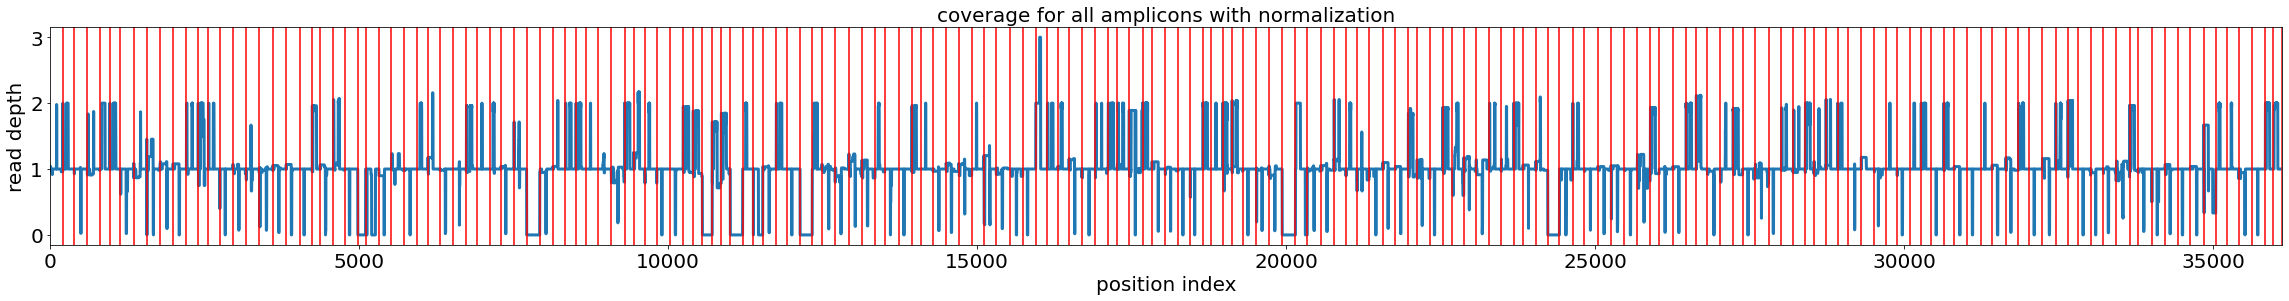

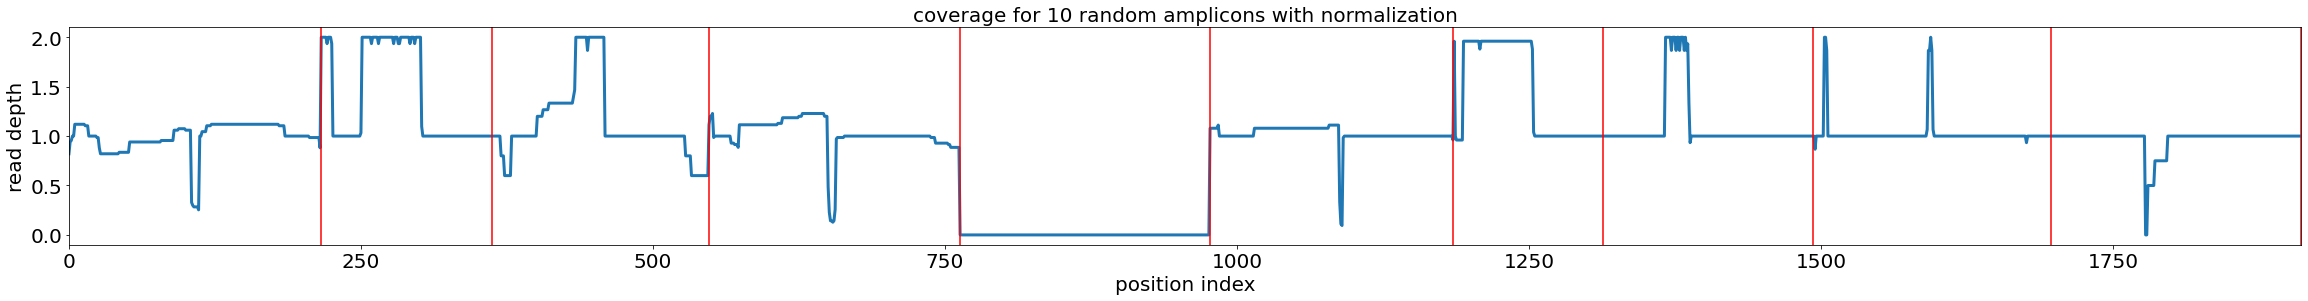

In [32]:
plot_cell_coverage(0)
plot_cell_coverage(0, nprobe = 10)

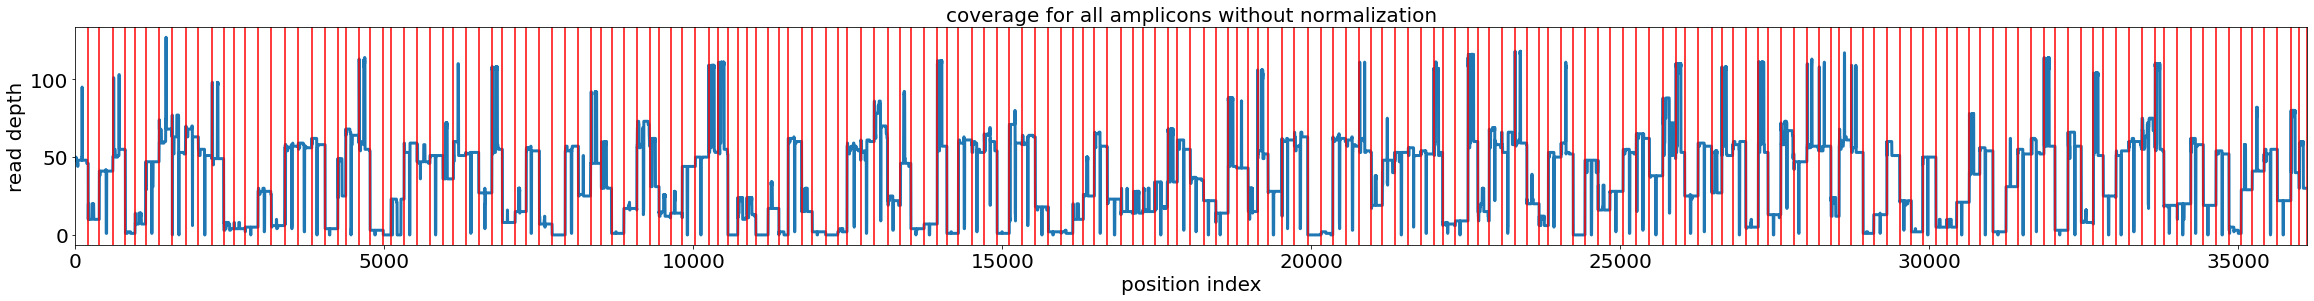

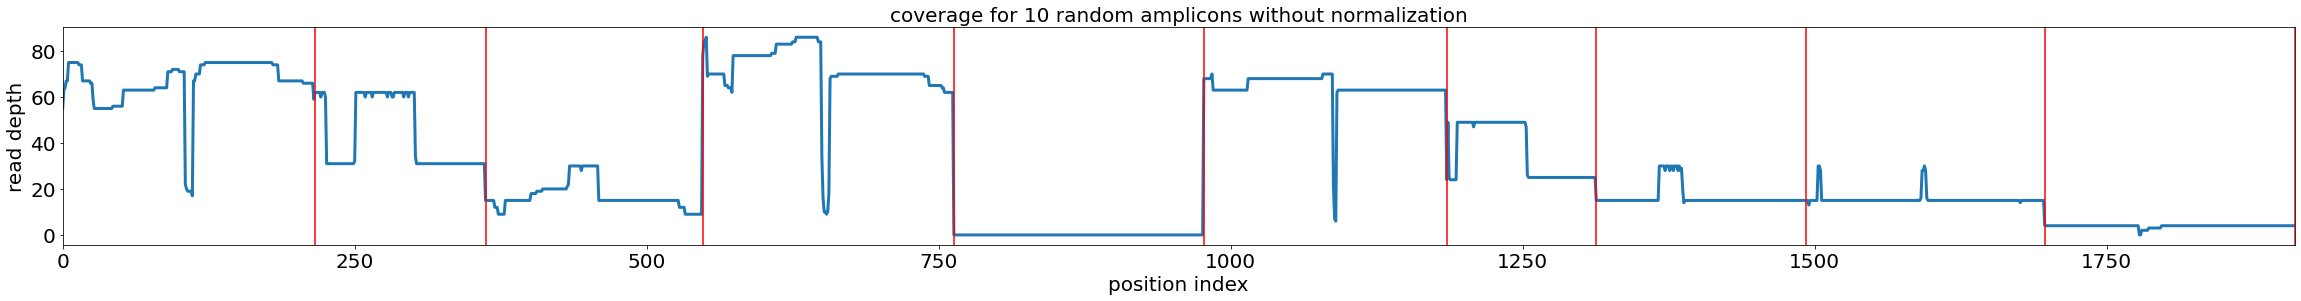

In [33]:
plot_cell_coverage(0, norm_flag=False)
plot_cell_coverage(0, nprobe = 10, norm_flag=False)

In [34]:
probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9]

In [37]:
def plot_quantile_distribution(probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9], trim_perc = 0, read_depth_threshold = 0):

    qrecord = None
    for amplicon in amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        median_depths = np.median(a, axis = 0)
        a_filtered = a[:, median_depths > read_depth_threshold]
        a_filtered_normalized = a_filtered / np.median(a_filtered, axis = 0)

        if qrecord is not None:
            qrecord = np.hstack((qrecord, np.quantile(a_filtered_normalized, probe_quantile, axis = 0)))
        else:
            qrecord = np.quantile(a_filtered_normalized, probe_quantile, axis = 0)
        
    return qrecord
#     for idx in len(probe_quantile):
#         fig, ax = plt.subplots(1,1,figsize=(6,4))
#         plt.hist(qrecord[idx,:], bins = 20)
#         plt.gca().set_ylabel(f"({probe_quantile[idx]}th quantile)/median")
#         plt.gca().set_xlabel(f"# amplicons across cells")

In [38]:
qrecord = plot_quantile_distribution()

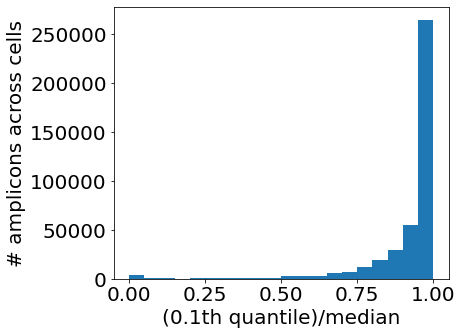

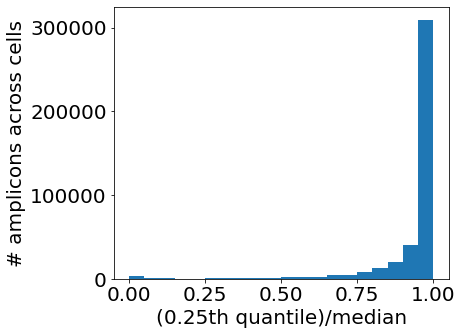

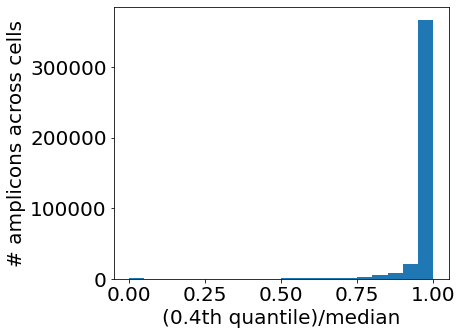

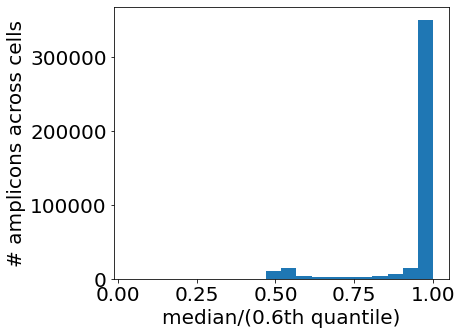

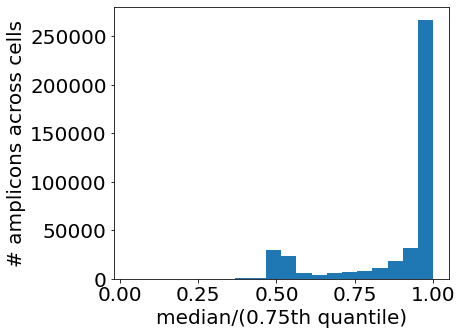

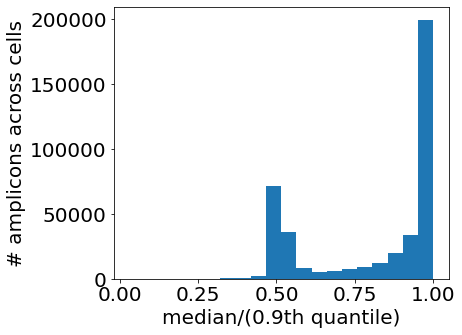

In [39]:
for idx in range(len(probe_quantile)):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    if probe_quantile[idx] > 0.5:
        plt.hist(np.reciprocal(qrecord[idx,:]), bins = 20)
        plt.gca().set_xlabel(f"median/({probe_quantile[idx]}th quantile)")
    else:
        plt.hist(qrecord[idx,:], bins = 20)
        plt.gca().set_xlabel(f"({probe_quantile[idx]}th quantile)/median")
    plt.gca().set_ylabel(f"# amplicons across cells")
#     if probe_quantile[idx] > 0.5:
#         plt.xlim((1,15))

In [40]:
def get_read_depth_heatmap(amplicon_threshold = 0, trim_perc = 0, read_depth_threshold = 0):
    
    namplicon = len(amplicon_list)
    read_depth = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    read_depth = read_depth[:, np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon]

    return read_depth

In [41]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0, read_depth_threshold = 0)

In [43]:
read_depth.shape

(186, 2374)

In [44]:
np.sum(read_depth, axis = 0).shape

(2374,)

In [45]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 28.0, 'cells')

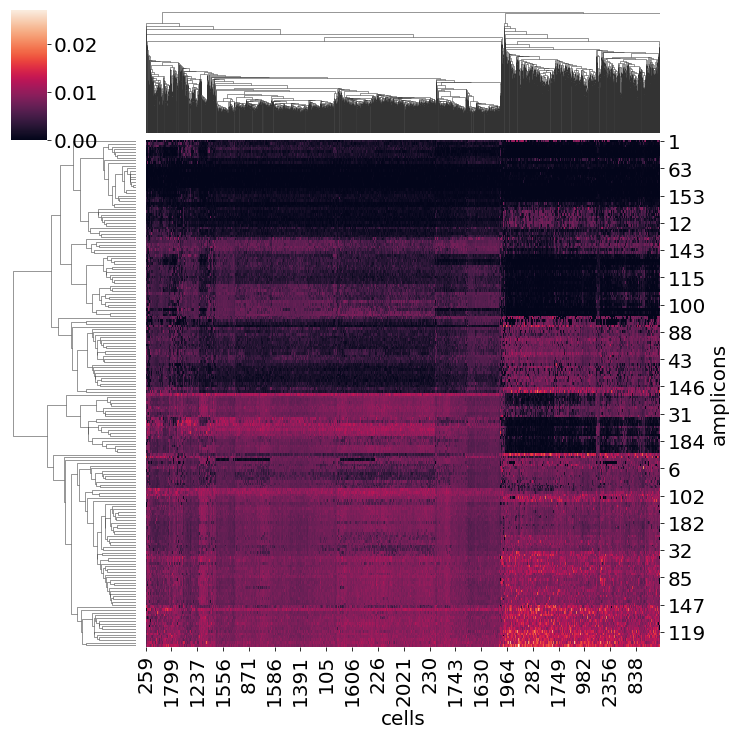

In [46]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [47]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 28.0, 'cells')

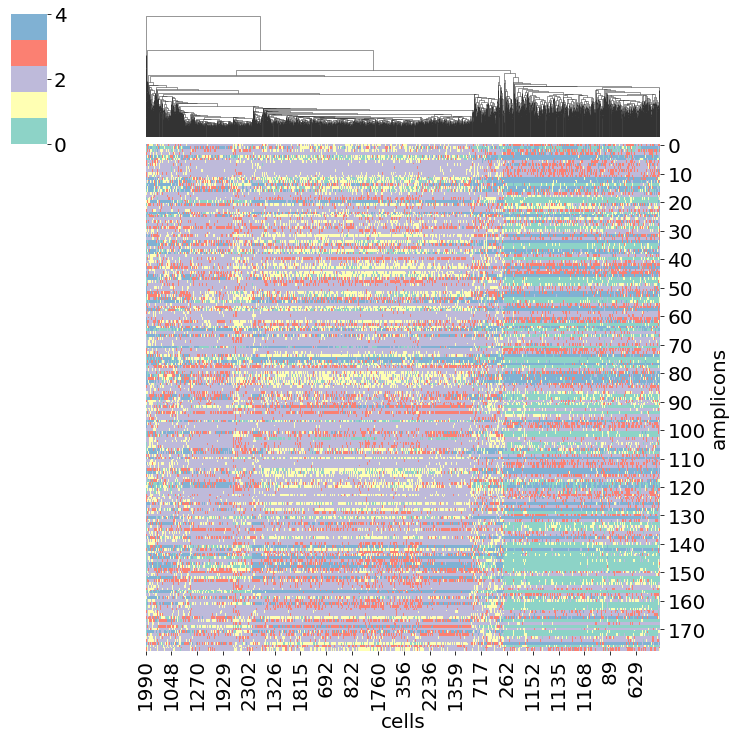

In [48]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=False, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [49]:
relative_normalized_read_depth.shape

(178, 2374)

**We filter the cells with low coverage this time**

In [50]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0.8, read_depth_threshold = 10)

In [51]:
read_depth.shape

(186, 1196)

In [52]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 28.0, 'cells')

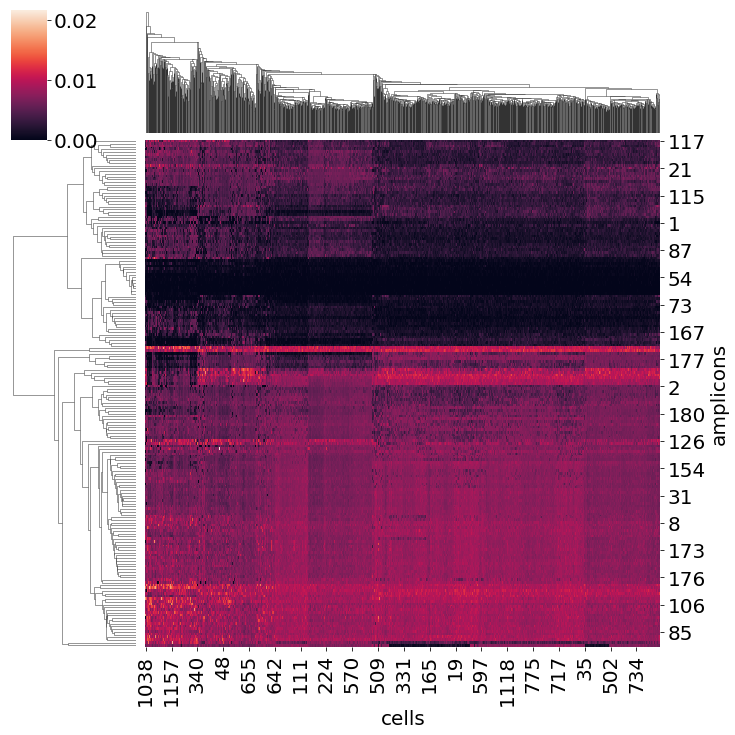

In [53]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [54]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 28.0, 'cells')

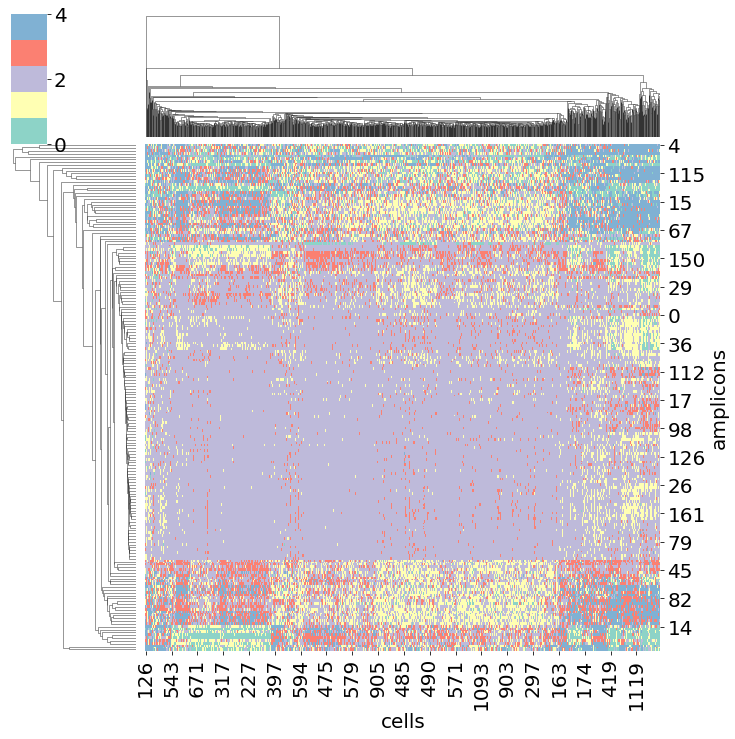

In [80]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### can we extracat normal cells?

we will try to use SNVs for this

In [56]:
def get_vaf_matrix(read_depth_threshold = 10, vaf_threshold = 0.1):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        # remove positions with total read depth less than read_depth_threshold
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a

    # remove positions with max vaf less than vaf_threshold
    return vaf_mat[np.max(vaf_mat, axis = 1) >= vaf_threshold, :]

In [57]:
vaf_mat = get_vaf_matrix(vaf_threshold = 0.2) # a bit more strict with the vaf_threshold here

In [58]:
vaf_mat.shape

(1141, 2374)

Text(0.5, 28.0, 'cells')

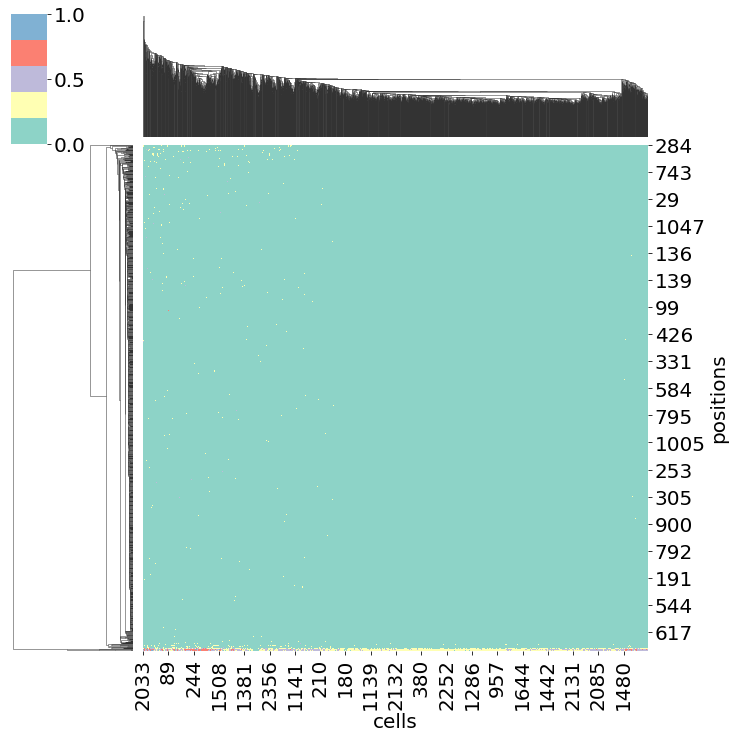

In [59]:
g = sns.clustermap(vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [60]:
filtered_vaf_mat = vaf_mat[np.median(vaf_mat, axis = 1) >= 0.2, :]

In [61]:
filtered_vaf_mat.shape

(5, 2374)

Text(0.5, 28.0, 'cells')

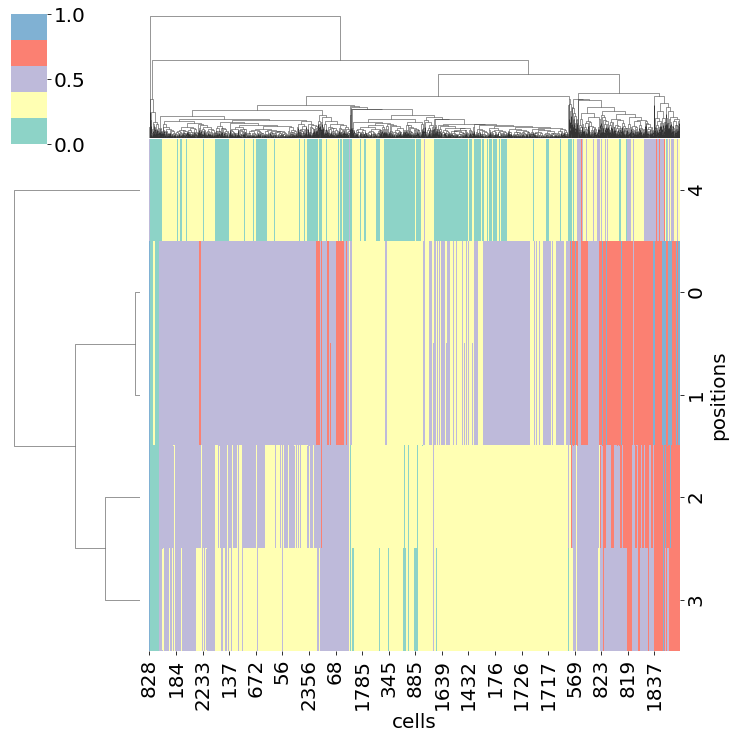

In [62]:
g = sns.clustermap(filtered_vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

What are these positions that are mutated in all the cells? Could it be SNPs? <br>
**TODO: download dbsnp database and cross-reference those positions** <br>
Quick fix: remove positions wtih median VAF across all cells more than 0.1

In [63]:
vaf_threshold = 0.1
filtered_vaf_mat = vaf_mat[np.median(vaf_mat, axis = 1) <= vaf_threshold, :]

In [64]:
filtered_vaf_mat.shape

(1135, 2374)

Text(0.5, 28.0, 'cells')

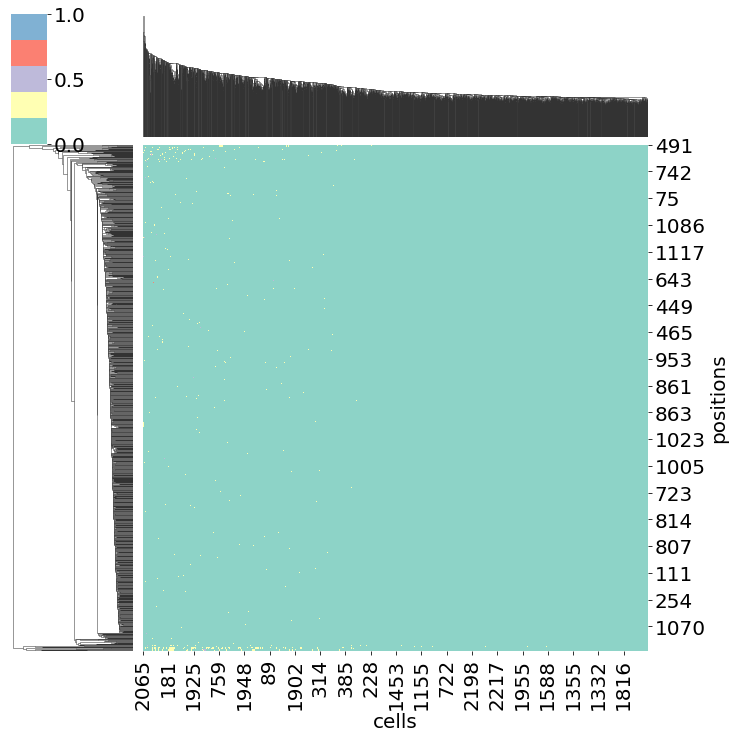

In [65]:
g = sns.clustermap(filtered_vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

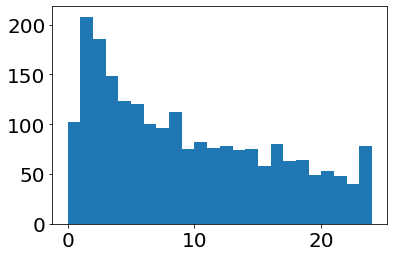

In [66]:
plt.hist(np.sum(filtered_vaf_mat > vaf_threshold, axis = 0), bins = np.arange(25));

In [67]:
print(f'tentative number of normal cells: {sum(np.sum(filtered_vaf_mat > vaf_threshold, axis = 0) == 0)}')

tentative number of normal cells: 102


**Plan: Use these normal cells to normalize total read counts and get copy numbers**

In [68]:
def get_normal_cell_indices(read_depth_threshold = 10, vaf_threshold = 0.1):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a

    # remove uninformative positions
    vaf_mat = vaf_mat[np.max(vaf_mat, axis = 1) >= vaf_threshold, :]
    
    # remove likely SNP positions
    vaf_mat = vaf_mat[np.median(vaf_mat, axis = 1) <= vaf_threshold, :]
    
    # count number of positions with VAF over the thershold for each cell
    position_count = np.sum(filtered_vaf_mat > vaf_threshold, axis = 0)
    
    return np.where(position_count == 0)[0]

In [69]:
normal_cell_indices = get_normal_cell_indices()

In [70]:
normal_cell_indices.shape

(102,)

In [71]:
normal_cell_indices

array([  13,   35,  238,  258,  265,  279,  286,  312,  356,  387,  455,
        459,  487,  520,  521,  578,  587,  614,  639,  647,  673,  682,
        683,  695,  718,  731,  733,  743,  748,  762,  807,  813,  863,
        888,  902,  910,  916,  921,  945,  953,  954,  960, 1003, 1015,
       1054, 1083, 1094, 1115, 1118, 1122, 1136, 1151, 1195, 1252, 1309,
       1346, 1366, 1367, 1370, 1371, 1401, 1402, 1452, 1469, 1487, 1491,
       1497, 1528, 1529, 1532, 1570, 1572, 1594, 1600, 1611, 1621, 1640,
       1677, 1686, 1713, 1750, 1753, 1762, 1796, 1848, 1851, 1912, 1939,
       1977, 1978, 2018, 2024, 2026, 2051, 2098, 2176, 2232, 2251, 2261,
       2274, 2282, 2333])

**Trying out these normal cells for read count normalization!**

In [72]:
def get_relative_read_depth(normal_cell_indices, amplicon_threshold = 0.8, trim_perc = 0, read_depth_threshold = 10):
    
    namplicon = len(amplicon_list)
    read_depth = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)
    
    # remove amplicons with median read depth acorss all cells equal to 0
    read_depth = read_depth[np.median(read_depth, axis = 1) > 0, :]
    
    # normalize the read dpeth in each cell by the total number of reads in that cell
    normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]
    normal_normalized_read_depth = normalized_read_depth[:, normal_cell_indices]
    normal_normalized_read_depth_median = np.median(normal_normalized_read_depth, axis=1)[:, None]
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold fraction of the amplicons
    read_depth = read_depth[:, np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon]
    # normalize the read dpeth in each cell by the total number of reads in that cell
    normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]
    # further normalize by the median read count of each amplicon in the normal cells
    relative_normal_normalized_read_depth = normalized_read_depth / normal_normalized_read_depth_median
    
    return relative_normal_normalized_read_depth

In [73]:
relative_normal_normalized_read_depth = get_relative_read_depth(normal_cell_indices)

In [74]:
relative_normal_normalized_read_depth.shape

(178, 1196)

Text(0.5, 28.0, 'cells')

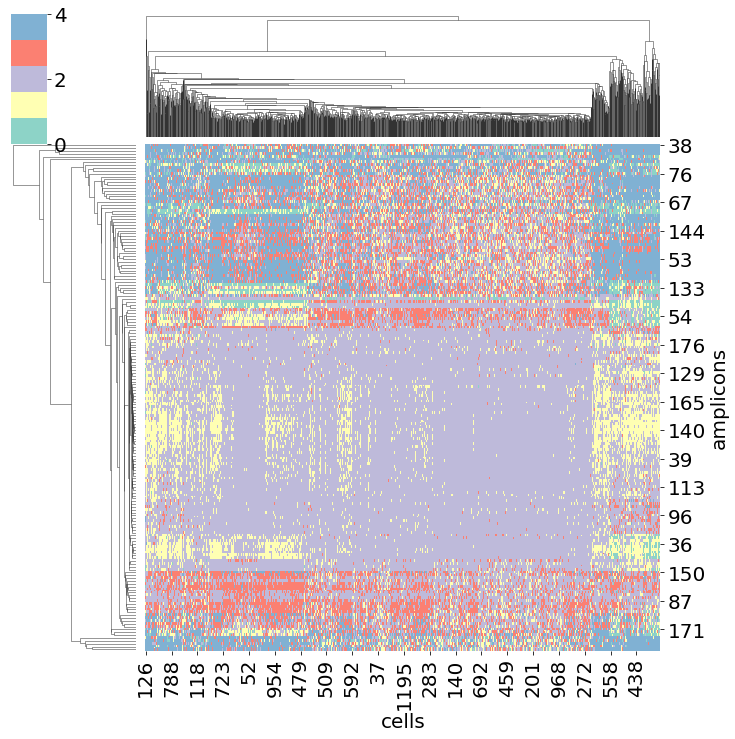

In [75]:
g = sns.clustermap(relative_normal_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [76]:
relative_normal_normalized_read_depth = get_relative_read_depth(normal_cell_indices, amplicon_threshold=0, read_depth_threshold=0)

Text(0.5, 28.0, 'cells')

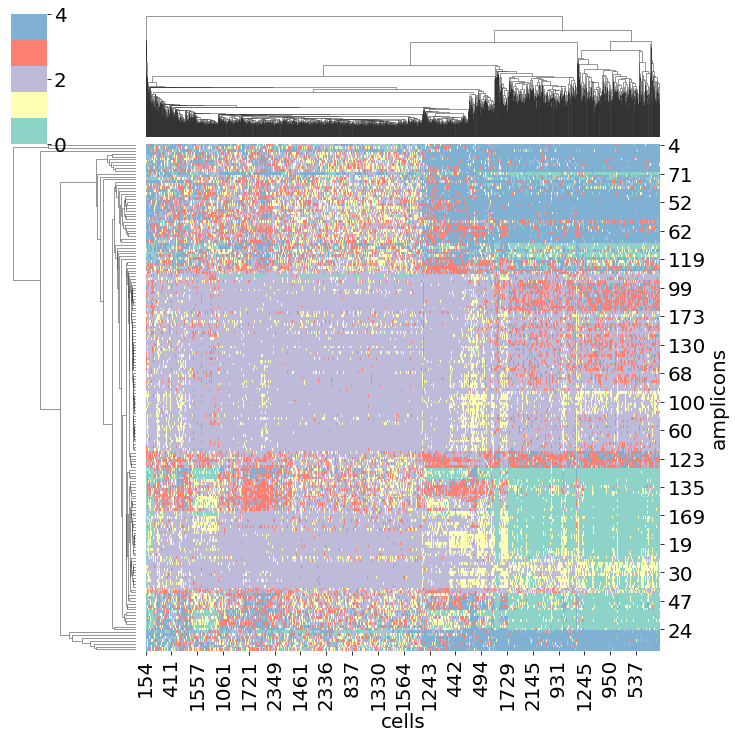

In [77]:
g = sns.clustermap(relative_normal_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### what does the heatmap look like if I only select the normal cells?

In [84]:
trim_perc = 0

namplicon = len(amplicon_list)
read_depth = None
for idx, amplicon in enumerate(amplicon_list):
    selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

    npos = len(selected_indices)
    if trim_perc > 0:
        cutoff = int(npos // (100 / trim_perc))
    else:
        cutoff = 0

    a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

    if read_depth is not None:
        read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
    else:
        read_depth = np.median(a, axis = 0)

# remove amplicons with median read depth acorss all cells equal to 0
read_depth = read_depth[np.median(read_depth, axis = 1) > 0, :]

# normalize the read dpeth in each cell by the total number of reads in that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]
normal_normalized_read_depth = normalized_read_depth[:, normal_cell_indices]
normal_normalized_read_depth_median = np.median(normal_normalized_read_depth, axis=1)[:, None]

relative_normal_normalized_read_depth_normal_cells = normal_normalized_read_depth / normal_normalized_read_depth_median

Text(0.5, 53.5, 'cells')

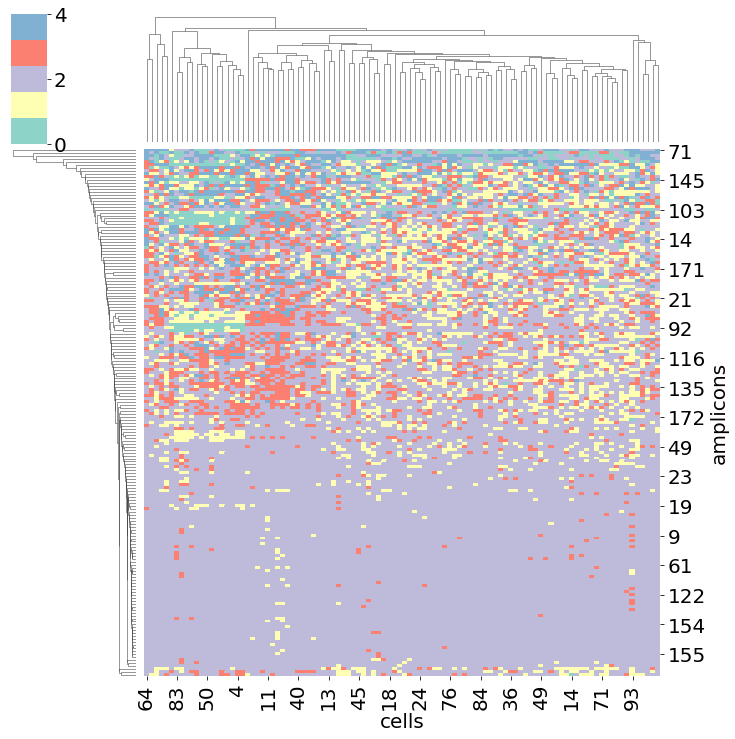

In [85]:
g = sns.clustermap(relative_normal_normalized_read_depth_normal_cells*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### look at read depth only at positions covered by the bulk sequencing data

In [78]:
cnp_file = '/n/fs/ragr-data/datasets/mskcc_iacobuzio/organoid/bams/hatchet/cn_profiles.tsv'

df_cnp = pd.read_csv(cnp_file, sep='\t')

In [81]:
cnp1_list = []
cnp2_list = []
for idx, row in df_unique_pos.iterrows():
    curr_pos = row['pos']
    curr_chrm = row['chrom']
    
    if curr_chrm != 'X':
        curr_chrm = int(curr_chrm)
        df_select = df_cnp[(df_cnp['#CHR'] == curr_chrm) & (df_cnp['START'] <= curr_pos) & (df_cnp['END'] >= curr_pos)][['cn_clone1', 'cn_clone2']]
#         df_select = df_cnp[(df_cnp['START'] <= curr_pos) & (df_cnp['END'] >= curr_pos)]
        if len(df_select) == 0:
            cnp1_list.append(np.nan)
            cnp2_list.append(np.nan)
        elif len(df_select) == 1:
            cnp1_list.append(df_select['cn_clone1'].values[0])
            cnp2_list.append(df_select['cn_clone2'].values[0])            
        else:
            print(row, 'more than one matches', sep='\n')
            break
    else:
        cnp1_list.append(np.nan)
        cnp2_list.append(np.nan)    
        
df_unique_pos['cn_clone1'] = cnp1_list
df_unique_pos['cn_clone2'] = cnp2_list

df_unique_pos_cn = df_unique_pos[df_unique_pos['cn_clone1'] == df_unique_pos['cn_clone1']]

In [82]:
df_unique_pos_cn

,pos,amplicon,chrom,ref,alt,ref_len,alt_len,normal,index,cn_clone1,cn_clone2
27595,77645600,AMPL87274,3,A,G,1,1,True,772,2|0,2|2
27618,77645623,AMPL87274,3,T,C,1,1,True,773,2|0,2|2
27619,77645624,AMPL87274,3,G,A,1,1,True,774,2|0,2|2
27673,77645678,AMPL87274,3,A,G,1,1,True,775,2|0,2|2
27699,77645704,AMPL87274,3,T,C,1,1,True,777,2|0,2|2
...,...,...,...,...,...,...,...,...,...,...,...
4582,12032538,AMPL87379,17,C,,1,0,False,33272,2|0,2|2
4584,12032540,AMPL87379,17,C,,1,0,False,33273,2|0,2|2
4585,12032541,AMPL87379,17,C,T,1,1,True,33274,2|0,2|2
4586,12032542,AMPL87379,17,GC,G,2,1,False,33275,2|0,2|2


In [83]:
normal_cell_indices

array([  13,   35,  238,  258,  265,  279,  286,  312,  356,  387,  455,
        459,  487,  520,  521,  578,  587,  614,  639,  647,  673,  682,
        683,  695,  718,  731,  733,  743,  748,  762,  807,  813,  863,
        888,  902,  910,  916,  921,  945,  953,  954,  960, 1003, 1015,
       1054, 1083, 1094, 1115, 1118, 1122, 1136, 1151, 1195, 1252, 1309,
       1346, 1366, 1367, 1370, 1371, 1401, 1402, 1452, 1469, 1487, 1491,
       1497, 1528, 1529, 1532, 1570, 1572, 1594, 1600, 1611, 1621, 1640,
       1677, 1686, 1713, 1750, 1753, 1762, 1796, 1848, 1851, 1912, 1939,
       1977, 1978, 2018, 2024, 2026, 2051, 2098, 2176, 2232, 2251, 2261,
       2274, 2282, 2333])

In [90]:
print(f"The bulk sequencing data only spans {len(df_unique_pos_cn['amplicon'].unique())} amplicons")

The bulk sequencing data only spans 22 amplicons


In [103]:
df_unique_pos_cn.groupby('amplicon')['cn_clone1'].value_counts()

amplicon   cn_clone1
AMPL40612  2|1          159
AMPL41099  2|0          197
AMPL52906  2|0          170
AMPL70352  2|1          205
AMPL70382  2|0          128
AMPL70423  2|1          214
AMPL87274  2|0          214
AMPL87275  2|0          208
AMPL87300  2|1          204
AMPL87301  2|1          209
AMPL87302  2|1          201
AMPL87303  2|1          220
AMPL87304  2|1          219
AMPL87308  2|1          216
AMPL87309  2|1          143
AMPL87310  2|1          218
AMPL87311  2|1          217
AMPL87312  2|1          204
AMPL87317  2|0          211
AMPL87376  2|0          216
AMPL87377  2|0          205
AMPL87379  2|0          215
Name: cn_clone1, dtype: int64

In [104]:
df_unique_pos_cn.groupby('amplicon')['cn_clone2'].value_counts()

amplicon   cn_clone2
AMPL40612  2|1          159
AMPL41099  2|2          197
AMPL52906  2|2          170
AMPL70352  2|1          205
AMPL70382  2|2          128
AMPL70423  2|1          214
AMPL87274  2|2          214
AMPL87275  2|2          208
AMPL87300  2|1          204
AMPL87301  2|1          209
AMPL87302  2|1          201
AMPL87303  2|1          220
AMPL87304  2|1          219
AMPL87308  2|1          216
AMPL87309  2|1          143
AMPL87310  2|1          218
AMPL87311  2|1          217
AMPL87312  2|1          204
AMPL87317  2|2          211
AMPL87376  2|2          216
AMPL87377  2|2          205
AMPL87379  2|2          215
Name: cn_clone2, dtype: int64

In [93]:
cn_amplicon_list = list(df_unique_pos_cn['amplicon'].unique())

In [105]:
def get_cn_relative_read_depth(normal_cell_indices, amplicon_list, amplicon_threshold = 0.8, trim_perc = 0, read_depth_threshold = 10):
    
    namplicon = len(amplicon_list)
    read_depth = None
    
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos_cn[df_unique_pos_cn['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)
    
    # remove amplicons with median read depth acorss all cells equal to 0
    read_depth = read_depth[np.median(read_depth, axis = 1) > 0, :]
    
    # normalize the read dpeth in each cell by the total number of reads in that cell
    normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]
    normal_normalized_read_depth = normalized_read_depth[:, normal_cell_indices]
    normal_normalized_read_depth_median = np.median(normal_normalized_read_depth, axis=1)[:, None]
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    read_depth = read_depth[:, np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon]
    # normalize the read dpeth in each cell by the total number of reads in that cell
    normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]
    # further normalize by the median read count of each amplicon in the normal cells
    relative_normal_normalized_read_depth = normalized_read_depth / normal_normalized_read_depth_median
    
    return relative_normal_normalized_read_depth

In [107]:
cn_relative_normal_normalized_read_depth = get_cn_relative_read_depth(normal_cell_indices, cn_amplicon_list)

In [108]:
cn_relative_normal_normalized_read_depth.shape

(22, 1994)

Text(0.5, 28.0, 'cells')

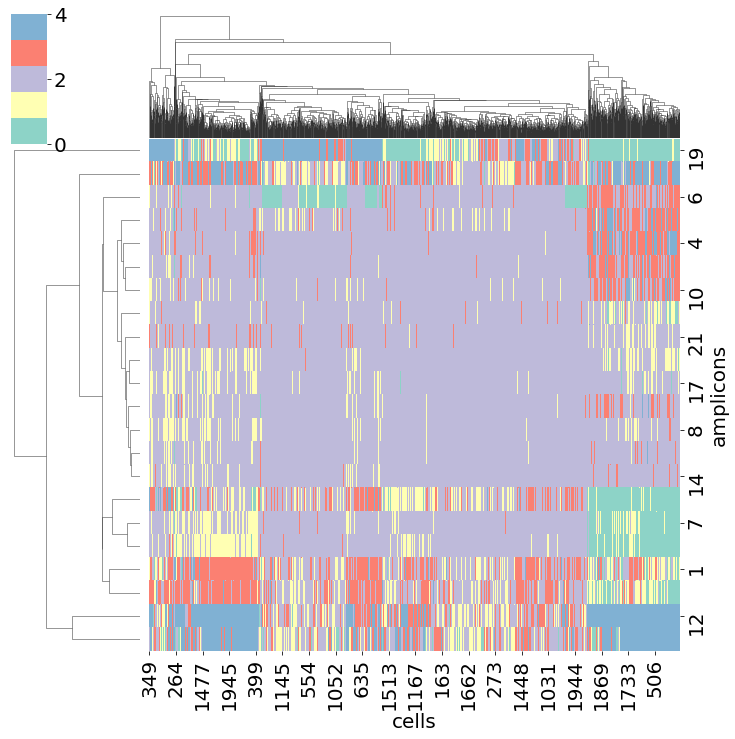

In [109]:
g = sns.clustermap(cn_relative_normal_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### focusing on amplicons where the two bulk CNA clones identified by Hatchet differ

In [112]:
cn_relative_normal_normalized_read_depth = get_cn_relative_read_depth(normal_cell_indices, list(df_unique_pos_cn[df_unique_pos_cn['cn_clone1'] == '2|0']['amplicon'].unique()))

Text(0.5, 28.0, 'cells')

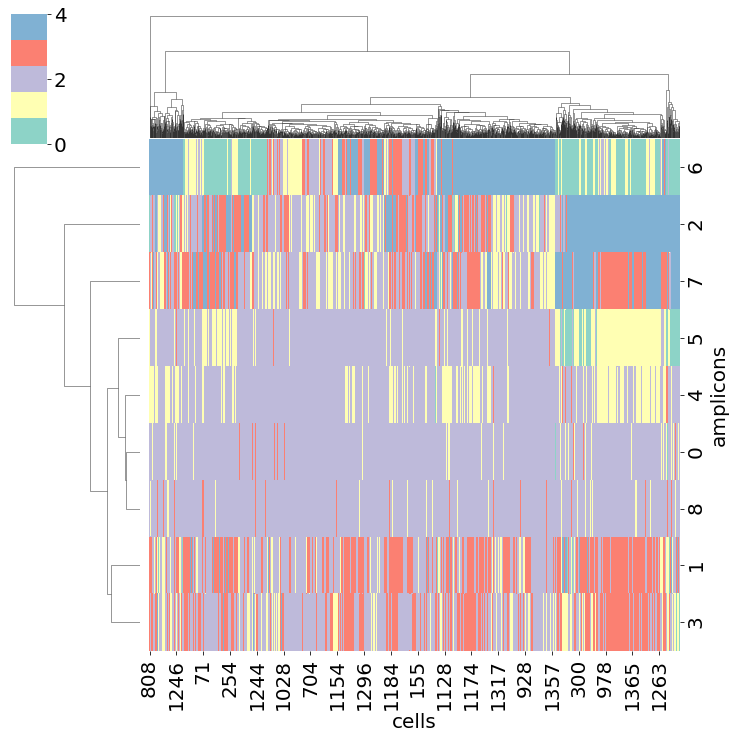

In [114]:
g = sns.clustermap(cn_relative_normal_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### focusing on amplicons wher the two bulk CNA clones identfied by Hatchet are the indistinguishible

In [115]:
cn_relative_normal_normalized_read_depth = get_cn_relative_read_depth(normal_cell_indices, list(df_unique_pos_cn[df_unique_pos_cn['cn_clone1'] == '2|1']['amplicon'].unique()))

Text(0.5, 28.0, 'cells')

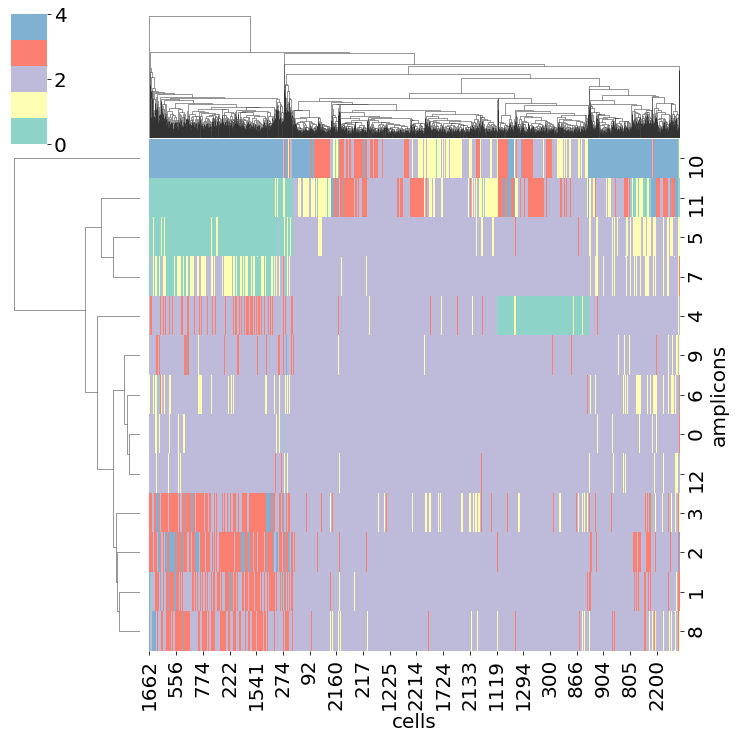

In [116]:
g = sns.clustermap(cn_relative_normal_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### can we at least see some evidence of LOH in the SNV data?

In [179]:
def get_selected_vaf_matrix(amplicon_list, read_depth_threshold = 10, vaf_threshold = 0.1):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos_cn[df_unique_pos_cn['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]

        # remove positions with total read depth less than read_depth_threshold
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a
            
    return vaf_mat[np.median(np.nan_to_num(vaf_mat), axis = 1) >= vaf_threshold, :]

In [183]:
selected_vaf_matrix = get_selected_vaf_matrix(list(df_unique_pos_cn[df_unique_pos_cn['cn_clone1'] == '2|0']['amplicon'].unique()), vaf_threshold=0.1, read_depth_threshold = 0)

<ipython-input-179-90f6369465dd>:18: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = b / a
<ipython-input-179-90f6369465dd>:16: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = np.vstack((vaf_mat, b / a))


In [184]:
selected_vaf_matrix.shape

(8, 2374)

Text(0.5, 28.0, 'cells')

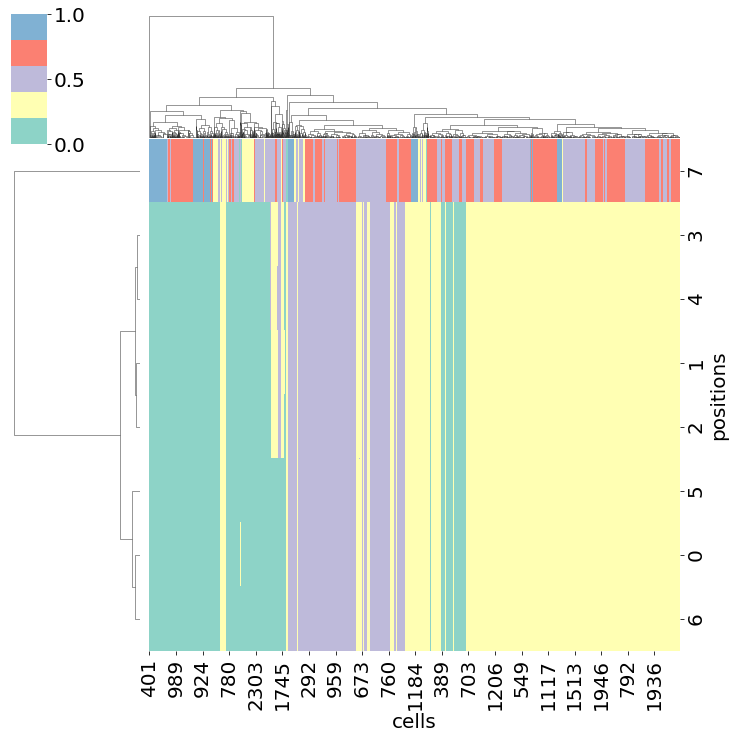

In [185]:
g = sns.clustermap(np.nan_to_num(selected_vaf_matrix), row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### lets try the condensed vaf matrix

In [186]:
def get_condensed_vaf_matrix(read_depth_threshold = 10, vaf_threshold = 0.1, presence_threshold = 0.05):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        # remove positions with total read depth less than read_depth_threshold
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a

    # remove positions with max vaf less than vaf_threshold
    vaf_mat = vaf_mat[np.max(vaf_mat, axis = 1) >= vaf_threshold, :]
    
    # remove positions with vaf less than vaf_threshold in less than presense_threshold fraction of the cells
    ncells = vaf_mat.shape[1]
    vaf_threshold_cell_count = (vaf_mat >= vaf_threshold).sum(axis = 1)
    return vaf_mat[vaf_threshold_cell_count >= presence_threshold*ncells, :]

In [ ]:
condensed_vaf_mat = get_condensed_vaf_matrix() 

In [ ]:
condensed_vaf_mat.shape

In [169]:
np.nan_to_num(selected_vaf_matrix).max()

1.0

In [870]:
relative_normal_normalized_read_depth.shape

(178, 2374)

In [ ]:
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth[:, normal_cell_indices], axis = 1) > 0, :]
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

In [706]:
sum(np.max(vaf_mat, axis = 1) >= 0.25)

760

In [653]:
a = a[:, np.sum(a >= 10, axis = 0) >= 0.9*186]

In [655]:
a.shape

(186, 116)

In [640]:
np.sum(a >= 10, axis = 0)

array([146, 144, 163, ..., 120, 144, 158])

In [643]:
(np.sum(a >= 10, axis = 0) >= 0.9*186).shape

(2374,)

In [629]:
a[:, np.sum(a > 0, axis = 0) > 2]

array([[48., 28., 55., ..., 53., 40., 39.],
       [10., 11., 15., ..., 12., 24., 16.],
       [41., 25., 47., ..., 60., 43., 34.]])